In [14]:
import rampy as rp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime
import os

from pydantic import BaseModel
from typing import List

import matplotlib.dates as mdates
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from scipy.signal import savgol_filter

In [15]:
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

## OGTT result

Let's plot how the OGTT went for s1, s2, s3, and s4

In [16]:
subj_ids = ['s1','s2','s3','s4','s5','s6','s7','s8']
datas = []

basepath = "../../data/pilot"
for subj_id in subj_ids:
    filepath = os.path.join(basepath, f"{subj_id}.csv")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not found")
    df = pd.read_csv(filepath,parse_dates=['time'], dtype={'glucose':'float',
                                    'prefix':'string'},index_col="time")
    datas.append(df)
    del(df)


In [17]:
today = datetime.today().replace(hour=1, minute=0, second=0, microsecond=0)

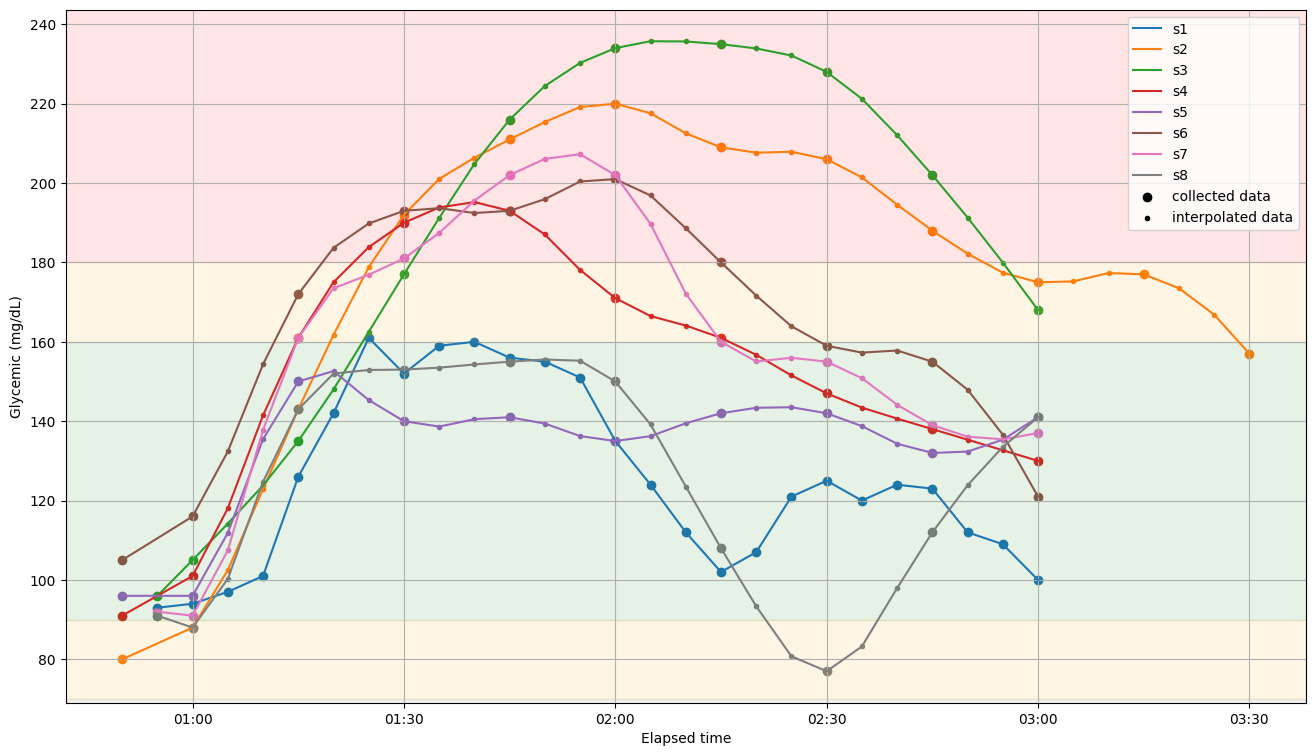

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
color_list = list(colors.TABLEAU_COLORS.values())
glucoses = []
for index, (subj_id, data) in enumerate(zip(subj_ids, datas)):
    y = data.glucose
    x = y.index
    y = y.interpolate(method='polynomial', order=2)
    glucoses += list(y)
    elapse = x - x[1]
    ax.scatter(elapse + today, y, c=color_list[index], marker='.')
    ax.scatter(elapse + today, data.glucose, c=color_list[index])
    ax.plot(elapse + today, y, label=subj_id, color=color_list[index])
    # Update the interpolated data
    data.glucose = y

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.scatter(0,0, marker='o', label='collected data', c='black')
ax.scatter(0,0, marker='.', label='interpolated data', c='black')
# ax.set_title("A result of OGTT of 8 participants with polynomial interpolation")
ax.set_xlabel("Elapsed time")
ax.set_ylabel("Glycemic (mg/dL)")
axisx_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(axisx_format)
ax.axhspan(60,70, color='grey', alpha=0.1)
ax.axhspan(70,90, color='orange', alpha=0.1)
ax.axhspan(90,160, color='green', alpha=0.1)
ax.axhspan(160,180, color='orange', alpha=0.1)
ax.axhspan(180,250, color='red', alpha=0.1)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.grid()
plt.show()

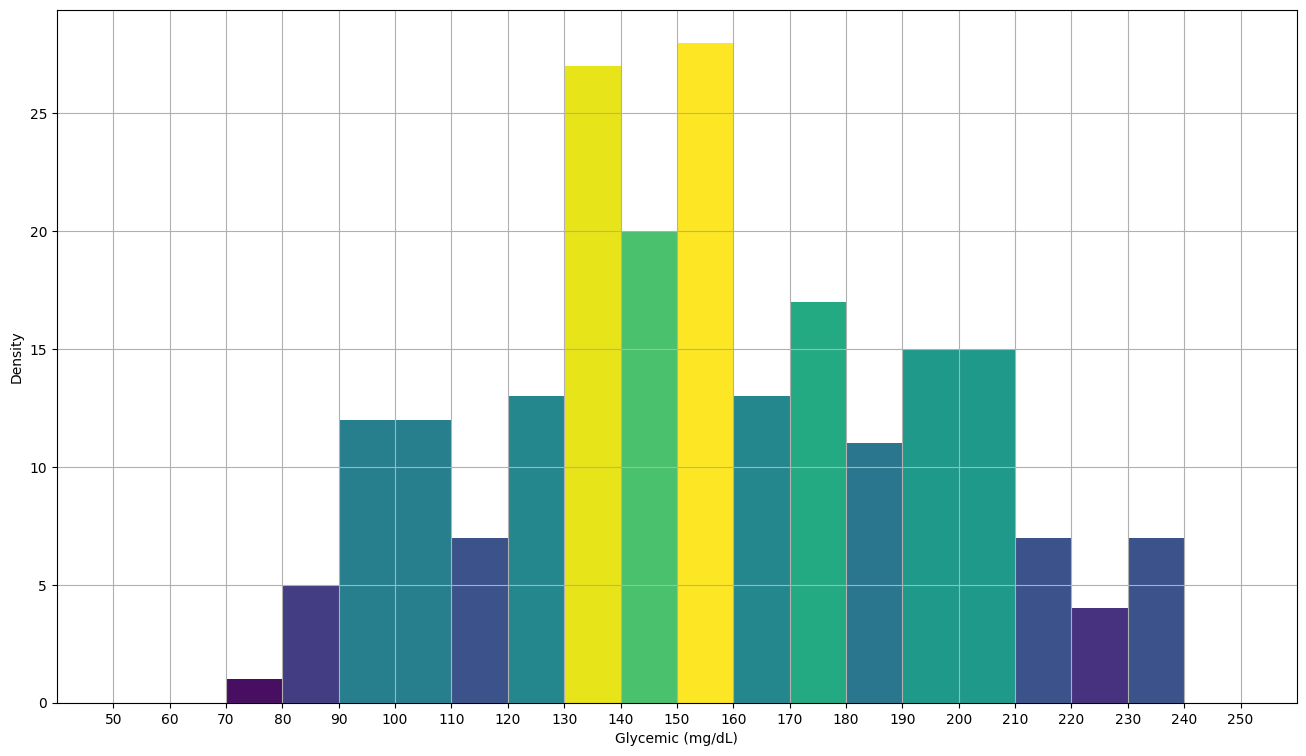

In [19]:
fig, ax = plt.subplots(figsize=(16,9))
bins = range(50,251,10)
N, bins, patches = ax.hist(x=glucoses, bins=bins)
# We'll color code by height, but you could use any scalar
fracs = N / N.max()
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# ax.set_title("Glycemic distribution from 8 participants")
ax.set_xlabel("Glycemic (mg/dL)")
ax.set_ylabel("Density")
ax.set_xticks(ticks=bins)
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
# ax.axhspan(60,70, color='grey', alpha=0.1)
# ax.axhspan(70,90, color='orange', alpha=0.1)
# ax.axhspan(90,160, color='green', alpha=0.1)
# ax.axhspan(160,180, color='orange', alpha=0.1)
# ax.axhspan(180,250, color='red', alpha=0.1)
# ax.legend()
ax.grid()
plt.show()

## Raman Measurement

In [20]:
def lower_thres(point:float, ratio:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag - (sign * (mag * ratio)))
    return point

def higher_thres(point:float, ratio:float) -> float:
    sign = np.sign(point)
    mag = abs(point)
    point = sign * (mag + (sign * (mag * ratio)))
    return point

def standardized(data:np.array) -> np.array:
    assert data.ndim == 1
    x = data.copy()
    # x_i = x_i - mean / std
    mean = x.mean()
    std = x.std()
    # print(mean, std)
    x = (x - mean)/std
    return x

def normalization(data:np.array) -> np.array:
    assert data.ndim == 1
    x = data.copy()
    min = x.min()
    max = x.max()
    x = (x - min)/(max - min)
    return x
# normalization(y)

def butter_lowpass_filter(data:np.array, normal_cutoff:float, order:int=1):
    from scipy.signal import butter,filtfilt
    y = data.copy()
    # normal_cutoff = cutoff / (fs * 0.5)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, y)
    return y

def butter_highpass_filter(data:np.array, normal_cutoff:float, order:int=1):
    from scipy.signal import butter,filtfilt
    y = data.copy()
    # normal_cutoff = cutoff / (fs * 0.5)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, y)
    return y

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores

# The next function calculates the average values around the point to be replaced.
def despike(y:np.array,window_size:int=20) -> np.array:
    ma = window_size//2
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    # print(spikes.any())
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            y_out[i] = np.mean(y[we])
    return y_out


In [21]:
x_range = XRange(lower_limit=900, higher_limit=1500)

# Load data into the column of df
for subj_id,data in zip(subj_ids, datas):
    spectrums = []
    for prefix in data.prefix:
        # Look for a file with this prefix
        file_lookup = os.path.join(basepath,subj_id,f"{prefix}_*")
        lookup_result = sorted(glob(file_lookup))
        assert len(lookup_result) != 0, f"{file_lookup=}, {lookup_result=}"
        # select the latest one
        filepath = lookup_result[-1]
        spectrum = load_data(filename=filepath, x_range=x_range, basepath="")
        spectrums.append(spectrum)
    data['spectrum'] = spectrums


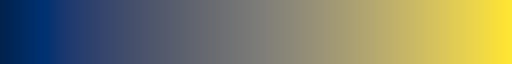

In [23]:
import peakutils.baseline as baseline
from matplotlib import colormaps, cm
cNorm = colors.Normalize(vmin=min(glucoses), vmax=max(glucoses))
cMap = cm.ScalarMappable(norm=cNorm, cmap=colormaps['cividis'])
colormaps['cividis']

In [24]:
def preprocessing_1(y:np.array) -> np.array:
    y = despike(y, window_size=25)
    y = standardized(y)
    bl = baseline(y, deg=4)
    y = y - bl
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    return y

def preprocessing_2(y:np.array) -> np.array:
    y = despike(y, window_size=25)
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    y = np.gradient(y, edge_order=1)
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    return y

def preprocessing_3(y:np.array) -> np.array:
    y = despike(y, window_size=25)
    y = butter_highpass_filter(data=y, normal_cutoff=0.01, order=1)
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=1)
    # y = butter_highpass_filter(data=y, normal_cutoff=0.01, order=1)
    return y

def preprocessing_4(y:np.array) -> np.array:
    y = despike(y, window_size=25)
    y = standardized(y)
    # bl = baseline(y, deg=4)
    # y = y - bl
    y = butter_lowpass_filter(data=y, normal_cutoff=0.1, order=2)
    return y



In [60]:
from pybaselines.polynomial import goldindec
from lmfit.models import LorentzianModel
from sklearn.metrics import auc

s1
s2
s3
s4
s5
s6
s7
s8


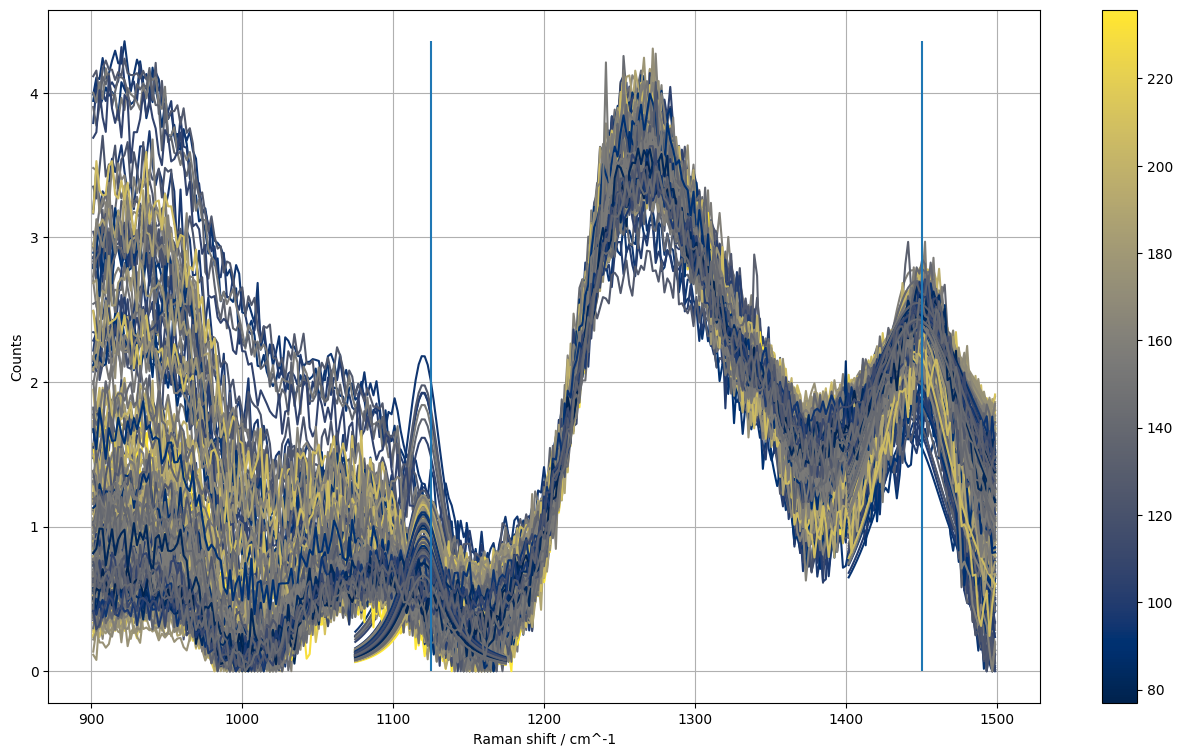

In [82]:
fig,ax = plt.subplots(figsize=(16,9))
ymin, ymax = np.inf, -1 * np.inf
range_1125 = (x >= 1075) & (x <= 1175)
range_1450 = (x >= 1400) & (x <= 1500)
for subj_id, data in zip(subj_ids, datas):
    print(subj_id)
    features = []
    auc_1125s = []
    auc_1450s = []
    for index,row in data.iterrows():
        glucose = row.glucose
        prefix = row.prefix
        x = row.spectrum[:,0].copy()
        y = row.spectrum[:,1].copy()

        y = despike(y, window_size=25)
        y = standardized(y)
        y = y + abs(y.min())

        # bl, _ = goldindec(data=y, x_data=x, poly_order=2)
        # y = y - bl

        model_1125 = LorentzianModel()
        params_1125 = model_1125.make_params()
        params_1125['center'].set(1125, min=1120, max=1130)
        params_1125['sigma'].set(16, min=15,max=17)
        result_1125 = model_1125.fit(y[range_1125], params_1125, x=x[range_1125])

        model_1450 = LorentzianModel()
        params_1450 = model_1450.make_params()
        params_1450['center'].set(1450)
        result_1450 = model_1450.fit(y[range_1450], params_1450, x=x[range_1450])

        auc_1125 = auc(x[range_1125], result_1125.best_fit)
        auc_1450 = auc(x[range_1450], result_1450.best_fit)
        # print(auc_1125)

        color = cMap.to_rgba(glucose)
        ax.plot(x,y, c=color)
        ax.plot(x[range_1125],result_1125.best_fit, c=color)
        ax.plot(x[range_1450],result_1450.best_fit, c=color)
        # ax.plot(x,bl, c=color, linestyle='--')
        if y.max() > ymax: ymax = y.max()
        if y.min() < ymin: ymin = y.min()
        features.append(y.copy())
        auc_1125s.append(auc_1125)
        auc_1450s.append(auc_1450)
        # break
    data['feature'] = features
    data['auc_1125'] = auc_1125s
    data['auc_1450'] = auc_1450s
    # break

fig.colorbar(cMap, ax=ax)
ax.set_xlabel('Raman shift / cm^-1')
ax.set_ylabel('Counts')
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)

ax.grid()
plt.show()

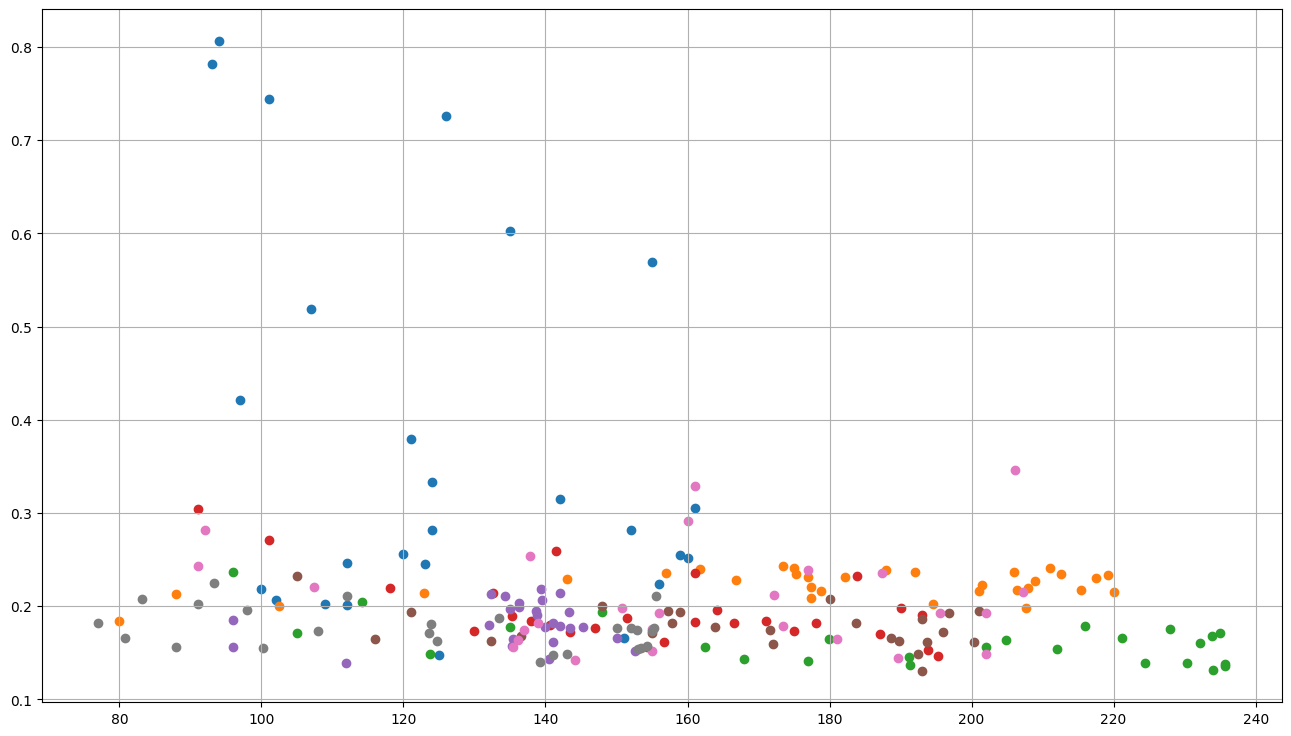

In [80]:
fig, ax = plt.subplots(figsize=(16,9))
for subj_id, data in zip(subj_ids, datas):
    glucoses = data['glucose']
    auc_1125s = data['auc_1125']
    auc_1450s = data['auc_1450']
    predicted = auc_1125s / auc_1450s
    ax.scatter(glucoses, predicted)
    # break
ax.grid()
plt.show()